## To predict employee attrition using CatBoost and XgBoost

## Dataset

The dataset used for this project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). It is a fictional dataset created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

In [3]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/wa_fn_usec_hr_employee_attrition_tsv.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Install CatBoost

In [48]:
!pip -qq install catboost
!pip install seaborn scikit-learn xgboost lightgbm hyperopt imblearn

  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/d8/0d/c3bfccc5d460eec8ff56889802aa88f5d07280d5282b307a74558e6edc44/imbalanced_learn-0.12.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 8.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Import Required Packages

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

## Load the Dataset

In [14]:
ibm_df = pd.read_csv('./wa_fn_usec_hr_employee_attrition_tsv.csv')
ibm_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [15]:
ibm_df.shape

(1470, 35)

In [16]:
ibm_df.over18.value_counts()

over18
Y    1470
Name: count, dtype: int64

In [17]:
ibm_df.employeecount.value_counts()

employeecount
1    1470
Name: count, dtype: int64

The above features that is employeecount and over18 has only one value throughout the records. Hence, they will be dropped.


In [18]:
ibm_df = ibm_df.drop(['employeenumber', 'employeecount','over18'], axis=1)
ibm_df.head(5)

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,80,1,6,3,3,2,2,2,2


In [19]:
# Shape of dataframe
ibm_df.shape

(1470, 32)

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Description

In [20]:
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in ibm_df.columns:
    obs = ibm_df[col].size
    p_nan = round(ibm_df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({ibm_df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if ibm_df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(ibm_df[col].unique())} labels' if dtype == 'categorical' else f'{ibm_df[col].min()}-{ibm_df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

#numerical.remove('employeecount')
numerical.remove('standardhours')
pd.set_option('display.max_columns', 100)
display(description)

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
observations(rows),1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
percent missing,0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,18-60,2 labels,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,2 labels,11-25,3-4,1-4,80-80,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17


The data isn't missing any values and we can spend more time on comparing different gradient boosted tree algorithms. First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

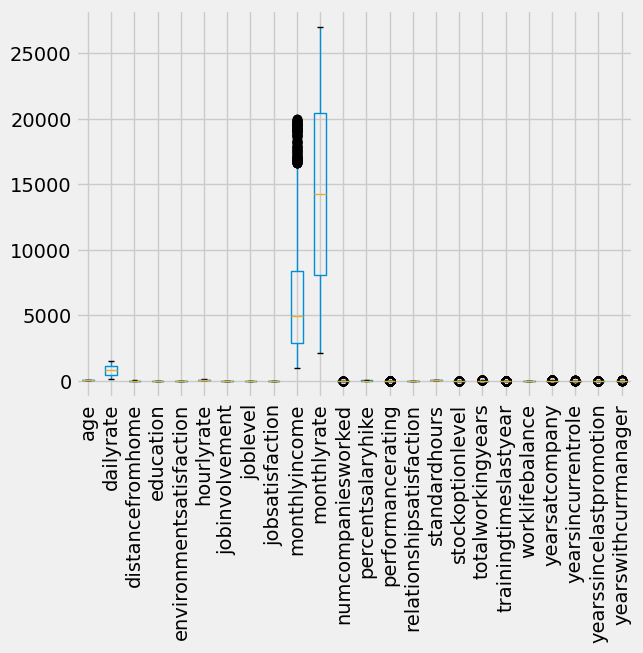

In [21]:
# Check for outliers
ibm_df.boxplot(rot = 90)
plt.show()

### Handing outliers

**Use lower bound as 25% and upper bound as 75% to handle the outliers**

In [22]:
outlier_colms = ['monthlyincome', 'numcompaniesworked', 'stockoptionlevel',  'performancerating', 'totalworkingyears',
                 'trainingtimeslastyear', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']
ibm_df1 = ibm_df.copy()

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

for colm in outlier_colms:
    ibm_df1 = handle_outliers(ibm_df1, colm)

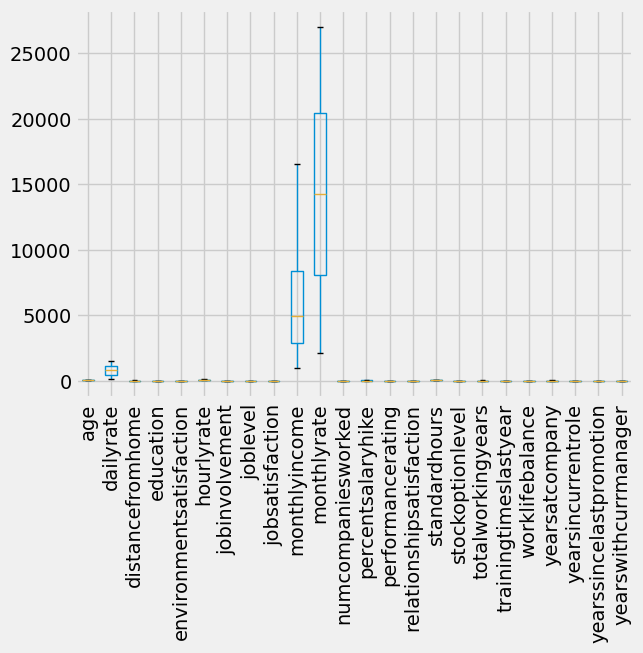

In [23]:
# Recheck for outliers
ibm_df1.boxplot(rot = 90)
plt.show()

### Target label imbalance

**Check if there is an imbalance in target label**

In [24]:
# Count of unique values in Attrition column
attrition_values = ibm_df1['attrition'].value_counts()
attrition_values

attrition
No     1233
Yes     237
Name: count, dtype: int64

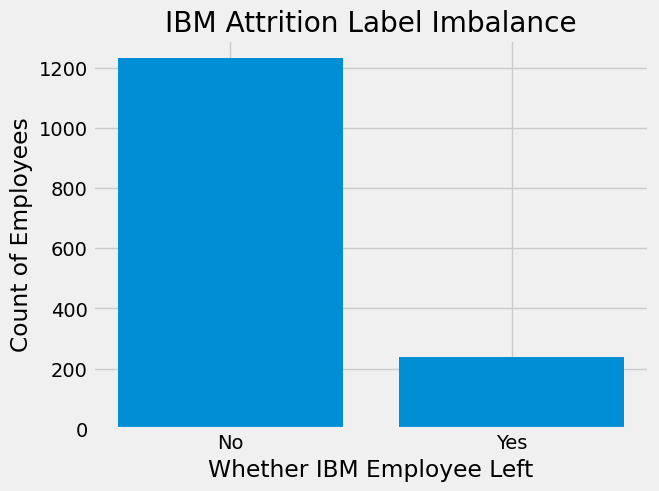

In [25]:
# Plot barplot
plt.bar(attrition_values.index, attrition_values.values)
plt.title('IBM Attrition Label Imbalance')
plt.xlabel('Whether IBM Employee Left')
plt.ylabel('Count of Employees')
plt.show()

###Plot pairplot

**Visualize the relationships between the predictor variables and the target variable using a pairplot**

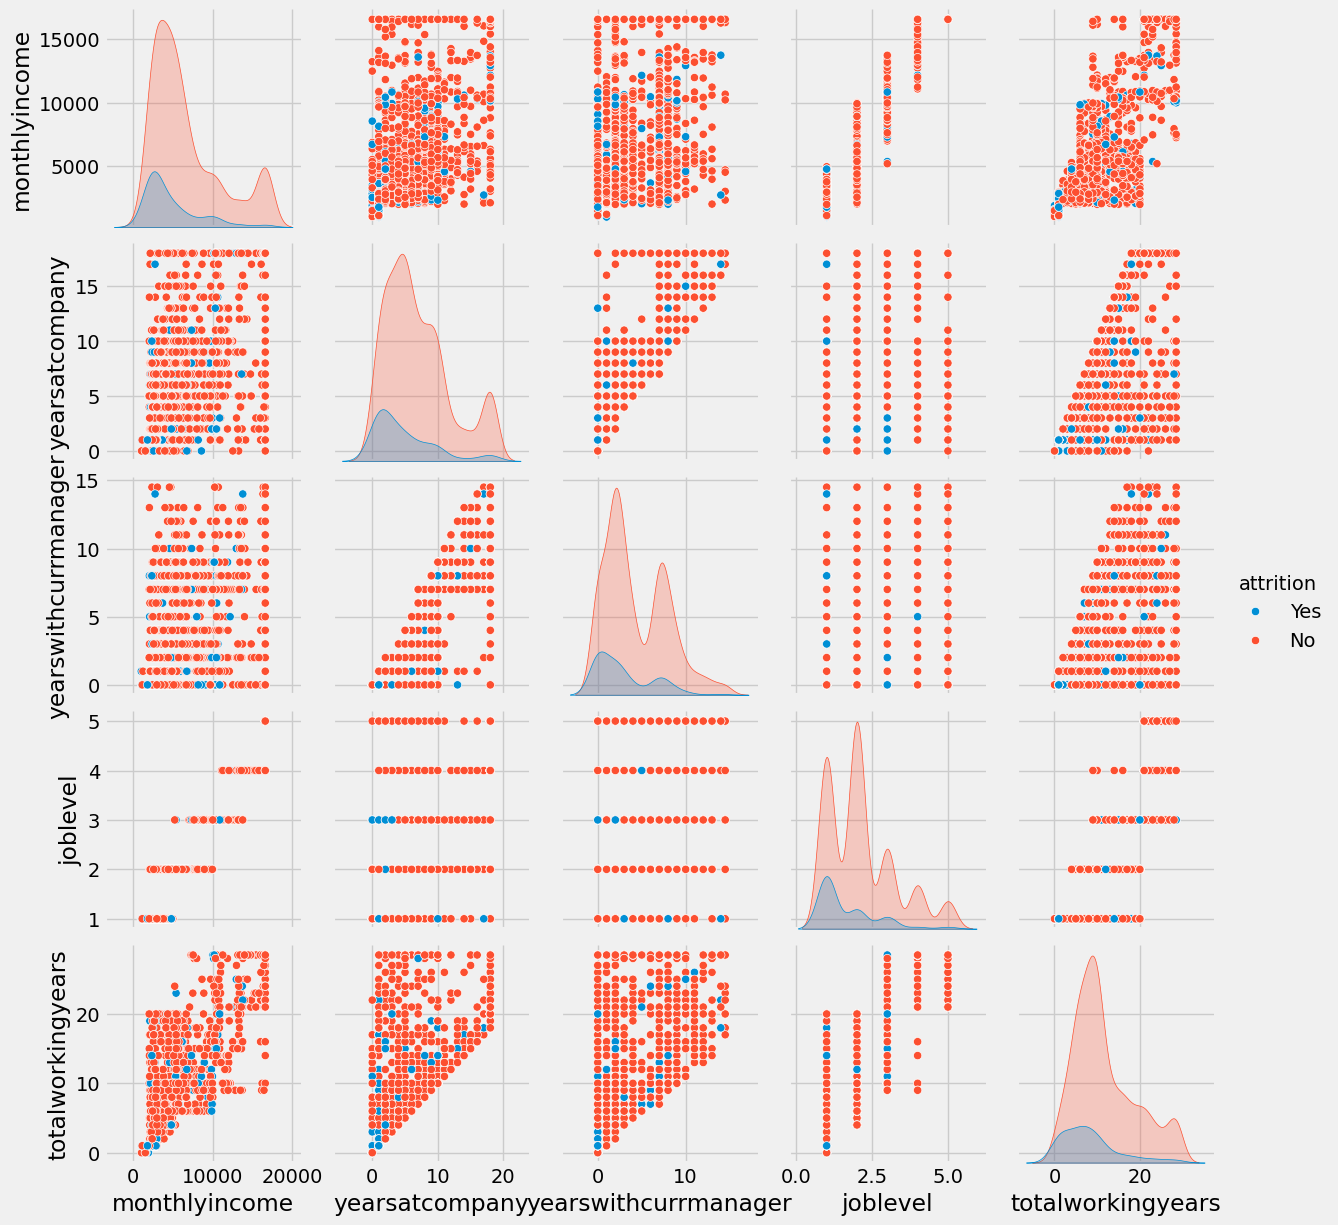

In [28]:
# Visualize a pirplot with few feature
features = ['monthlyincome', 'attrition', 'yearsatcompany', 'yearswithcurrmanager', 'joblevel', 'totalworkingyears']
pairplot = sns.pairplot(ibm_df1[features], diag_kind='kde', hue='attrition')
plt.show()

From the results it can see that the data has an imbalance in target labels. It has about a 6:1 *No* attrition label compared to *Yes*. The effect of the imbalance really shows up in the pairplots where the *yes* markers in the scatter plots are all but drowned out, though this would be less of a problem if the classes were more distinct. To test the model a smart thing to do would be to look at the confusion matrix and see how well the model performed on the minority class, *yes*.

### Explore Correlation

- Plotting the Heatmap

**Visualize the correlation among IBM employee attrition numerical features using a heatmap**

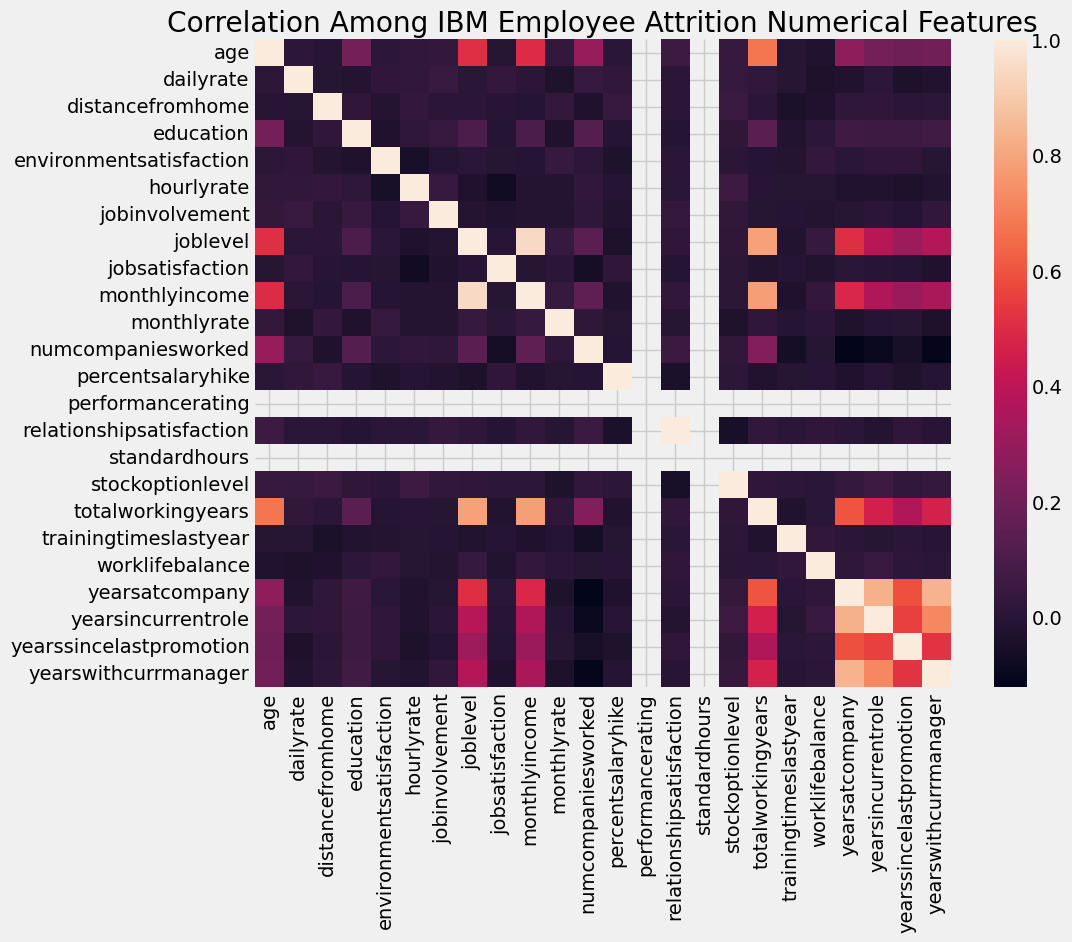

In [31]:
# Visualize heatmap
numeric_df = ibm_df1.select_dtypes(include='number')
plt.figure(figsize = (10, 8))
sns.heatmap(numeric_df.corr())
plt.title('Correlation Among IBM Employee Attrition Numerical Features')
plt.show()

In the pairplot, from the diagonal distributions it seems that there are no features that have drastically different distributions between the classes.

Lastly, plot the correlations between the features to look for colinear relationships. These are usually a problem for GBDTs but if there are many features with high correlation, some feature engineering can be done.

### Preparing the Validation Data

In [32]:
# Split into training and validation set
train_ibm_df, test_ibm_df = train_test_split(ibm_df1, test_size = 0.05, stratify = ibm_df1['attrition'], random_state = 123)
train_ibm_df.shape, test_ibm_df.shape

((1396, 32), (74, 32))

In [33]:
print("Attrition train")
print(train_ibm_df['attrition'].value_counts()/len(train_ibm_df))
print("Attrition test")
print(test_ibm_df['attrition'].value_counts()/len(test_ibm_df))

Attrition train
attrition
No     0.838825
Yes    0.161175
Name: count, dtype: float64
Attrition test
attrition
No     0.837838
Yes    0.162162
Name: count, dtype: float64


In [34]:
test_ibm_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
1294,41,No,Travel_Rarely,447,Research & Development,5,3,Life Sciences,2,Male,85,4,2,Healthcare Representative,2,Single,6870,15530,3.0,No,12,3,1,80,0.0,11.0,3.0,1,3,2.0,1.0,2.0
634,25,No,Travel_Rarely,141,Sales,3,1,Other,3,Male,98,3,2,Sales Executive,1,Married,4194,14363,1.0,Yes,18,3,4,80,0.0,5.0,3.0,3,5,3.0,0.0,3.0
60,32,No,Travel_Rarely,427,Research & Development,1,3,Medical,1,Male,33,3,2,Manufacturing Director,4,Married,6162,10877,1.0,Yes,22,3,2,80,1.0,9.0,3.0,3,9,8.0,7.0,8.0
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1.0,Yes,20,3,2,80,1.0,6.0,0.5,3,6,2.0,0.0,3.0
424,57,No,Travel_Rarely,210,Sales,29,3,Marketing,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3.0,No,12,3,3,80,1.0,28.5,3.0,2,1,0.0,0.0,0.0


In [35]:
categorical

['attrition',
 'businesstravel',
 'department',
 'educationfield',
 'gender',
 'jobrole',
 'maritalstatus',
 'overtime']

In [36]:
# Handling categorical features in test set
test_dummy = pd.get_dummies(test_ibm_df[categorical], drop_first=True)
test_dummy.head()

,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
1294,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
634,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True
60,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True
1467,False,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True
424,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [37]:
# Concat encoded features
test_ibm_df = pd.concat([test_ibm_df, test_dummy], axis=1)
# Drop original categorical columns
test_ibm_df.drop(columns = categorical, inplace=True)
test_ibm_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
1294,41,447,5,3,2,85,4,2,2,6870,15530,3.0,12,3,1,80,0.0,11.0,3.0,1,3,2.0,1.0,2.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
634,25,141,3,1,3,98,3,2,1,4194,14363,1.0,18,3,4,80,0.0,5.0,3.0,3,5,3.0,0.0,3.0,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True
60,32,427,1,3,1,33,3,2,4,6162,10877,1.0,22,3,2,80,1.0,9.0,3.0,3,9,8.0,7.0,8.0,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True
1467,27,155,4,3,2,87,4,2,2,6142,5174,1.0,20,3,2,80,1.0,6.0,0.5,3,6,2.0,0.0,3.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True
424,57,210,29,3,1,56,2,4,4,14118,22102,3.0,12,3,3,80,1.0,28.5,3.0,2,1,0.0,0.0,0.0,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [38]:
# Rename target column
test_ibm_df.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
test_ibm_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
1294,41,447,5,3,2,85,4,2,2,6870,15530,3.0,12,3,1,80,0.0,11.0,3.0,1,3,2.0,1.0,2.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
634,25,141,3,1,3,98,3,2,1,4194,14363,1.0,18,3,4,80,0.0,5.0,3.0,3,5,3.0,0.0,3.0,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True
60,32,427,1,3,1,33,3,2,4,6162,10877,1.0,22,3,2,80,1.0,9.0,3.0,3,9,8.0,7.0,8.0,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True
1467,27,155,4,3,2,87,4,2,2,6142,5174,1.0,20,3,2,80,1.0,6.0,0.5,3,6,2.0,0.0,3.0,False,False,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True
424,57,210,29,3,1,56,2,4,4,14118,22102,3.0,12,3,3,80,1.0,28.5,3.0,2,1,0.0,0.0,0.0,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [39]:
# Features
test_x = test_ibm_df.drop('attrition', axis=1)
# Targer label
test_y = test_ibm_df['attrition']

test_x.shape, test_y.shape

((74, 45), (74,))

# Hyperopt (Hyperparameter Tuning)

In [41]:
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break

    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    F1 = round(trials[fit_idx]['result']['f1 score'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'f1_score': F1,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Applying CatBoost

### Data Processing for CatBoost

In [42]:
cbo_data = train_ibm_df.copy()
cbo_data.shape

(1396, 32)

In [43]:
# Handling categorical features in train set
cbo_dummy = pd.get_dummies(cbo_data[categorical], drop_first=True)
cbo_dummy.head()

,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [44]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
cbo_data = pd.concat([cbo_data, cbo_dummy], axis=1)
cbo_data.drop(columns = categorical, inplace=True)
cbo_data.head(5)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [45]:
# Rename target column
cbo_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
cbo_data.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [46]:
# Features
x_df = cbo_data.drop('attrition', axis=1)
# Targer label
y_df = cbo_data['attrition']

x_df.shape, y_df.shape

((1396, 45), (1396,))

### SMOTE

In [51]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

<Axes: ylabel='count'>

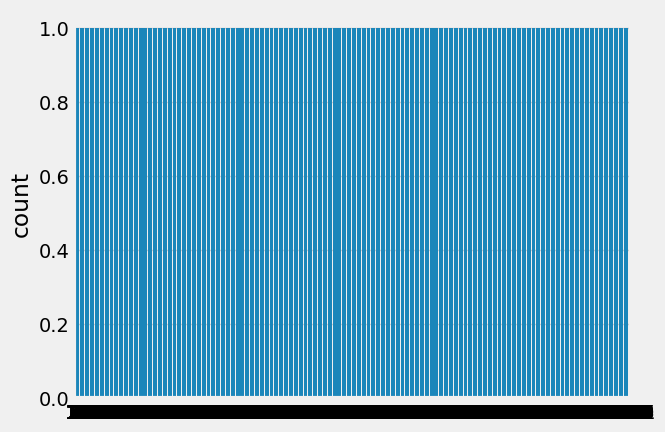

In [52]:
sns.countplot(y_df1, label = 'count')

After implementing SMOTE, x_df1 and y_df1 are the independent features and target labels simultaeneously.

If SMOTE is to be applied they can be used while training the model.

### Model Definition

In [53]:
def cat_objective(space):

    cboost = CatBoostClassifier(
    eval_metric  = 'AUC',
    learning_rate = space['learning_rate'],
    iterations = space['iterations'],
    depth = space['depth'],
    l2_leaf_reg = space['l2_leaf_reg'],
    border_count = space['border_count']
    )

    cboost.fit(x_df1, y_df1,
            cat_features=None)

    predictions = cboost.predict(test_x)
    test_preds = cboost.predict_proba(test_x)[:,1]
    train_preds = cboost.predict_proba(x_df1)[:,1]

    train_auc = roc_auc_score(y_df1, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1}

Hyperparameter tuning technique to optimize parameters for CatBoost (Optional).

In [ ]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'iterations': hp.quniform('iterations', 25, 1000, 25),
    'depth': hp.quniform('depth', 1, 16, 1),
    'border_count': hp.quniform('border_count', 30, 220, 5),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

cboost_hyperparams = fmin(fn = cat_objective,
                 max_evals = 150,
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
display(cbo_results)

In [55]:
# Create CatBoost model
cboost = CatBoostClassifier(learning_rate = 1,
                            depth = 1,
                            scale_pos_weight = 6,
                            l2_leaf_reg = 8,
                            border_count = 65)

In [56]:
cboost_dft = CatBoostClassifier()

In [57]:
cboost_dft.fit(x_df, y_df, cat_features = None)

Learning rate set to 0.01188
0:	learn: 0.6859974	total: 6.68ms	remaining: 6.67s
1:	learn: 0.6765186	total: 12.3ms	remaining: 6.12s
2:	learn: 0.6687943	total: 13.7ms	remaining: 4.57s
3:	learn: 0.6611175	total: 15.1ms	remaining: 3.75s
4:	learn: 0.6535010	total: 16.4ms	remaining: 3.26s
5:	learn: 0.6463304	total: 17.9ms	remaining: 2.97s
6:	learn: 0.6397001	total: 18.8ms	remaining: 2.67s
7:	learn: 0.6314023	total: 19.7ms	remaining: 2.44s
8:	learn: 0.6241990	total: 20.6ms	remaining: 2.26s
9:	learn: 0.6169518	total: 21.4ms	remaining: 2.12s
10:	learn: 0.6110061	total: 22.3ms	remaining: 2s
11:	learn: 0.6032202	total: 23.2ms	remaining: 1.91s
12:	learn: 0.5978248	total: 24ms	remaining: 1.82s
13:	learn: 0.5913539	total: 25ms	remaining: 1.76s
14:	learn: 0.5845326	total: 25.9ms	remaining: 1.7s
15:	learn: 0.5788629	total: 26.9ms	remaining: 1.66s
16:	learn: 0.5731824	total: 27.9ms	remaining: 1.61s
17:	learn: 0.5670415	total: 28.8ms	remaining: 1.57s
18:	learn: 0.5616820	total: 29.7ms	remaining: 1.53s
1

`Hyperopt`, hyperparameter tuning technique was used to idetify the best set of parameters.
* Different set of hyperparameters were giving good result.
* Out of them, one such set was chosen.

In [58]:
# Model training
cboost.fit(x_df, y_df, cat_features = None)

0:	learn: 0.6545710	total: 1.21ms	remaining: 1.21s
1:	learn: 0.6137222	total: 1.71ms	remaining: 854ms
2:	learn: 0.5981310	total: 2.05ms	remaining: 680ms
3:	learn: 0.5894095	total: 2.33ms	remaining: 579ms
4:	learn: 0.5705611	total: 2.6ms	remaining: 517ms
5:	learn: 0.5486327	total: 2.88ms	remaining: 477ms
6:	learn: 0.5321535	total: 3.19ms	remaining: 452ms
7:	learn: 0.5237834	total: 3.45ms	remaining: 428ms
8:	learn: 0.5184545	total: 3.75ms	remaining: 413ms
9:	learn: 0.5091408	total: 4.01ms	remaining: 397ms
10:	learn: 0.5008413	total: 5.02ms	remaining: 452ms
11:	learn: 0.4928861	total: 5.28ms	remaining: 435ms
12:	learn: 0.4855013	total: 5.54ms	remaining: 420ms
13:	learn: 0.4796767	total: 5.79ms	remaining: 408ms
14:	learn: 0.4739009	total: 6.08ms	remaining: 399ms
15:	learn: 0.4686959	total: 6.35ms	remaining: 391ms
16:	learn: 0.4647735	total: 6.63ms	remaining: 383ms
17:	learn: 0.4610028	total: 6.88ms	remaining: 375ms
18:	learn: 0.4563459	total: 7.16ms	remaining: 370ms
19:	learn: 0.4523837	to

### Model performance

In [60]:
# Model performance on all sets
predictions = cboost.predict(test_x)
test_preds = cboost.predict_proba(test_x)[:,1]
train_preds = cboost.predict_proba(x_df)[:,1]

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [61]:
F1 = f1_score(test_y, predictions)
print(F1)

0.5925925925925926


Confusion Matrix

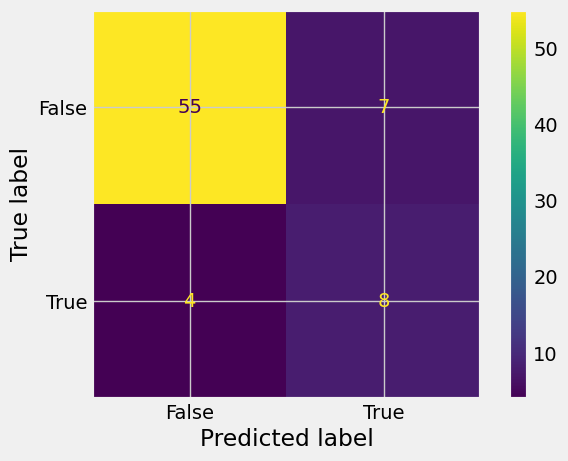

In [62]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

## Feature Importance (Optional)

In [63]:
features = x_df.columns
importances_cboost = cboost.feature_importances_

In [64]:
cboost_results = {'accuracy': accuracy,
                  'model': 'CatBoost',
                  'f1_score': F1,
                  'training auc score': train_auc,
                  'test auc score': test_auc}
cboost_results

{'accuracy': 0.8513513513513513,
 'model': 'CatBoost',
 'f1_score': 0.5925925925925926,
 'training auc score': np.float64(0.9798614669323465),
 'test auc score': np.float64(0.8817204301075269)}

After removing those features.
* f1 score fell below from 51 to 45.
* Overfitting reduced.

### K-fold cross validation

To use K-fold cross validation, training data file can be split into train and test sets using train_test_split method.

In [67]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)

In [68]:
for k, (train, test) in enumerate(kfold.split(x_df, y_df)):
    cboost.fit(x_df.iloc[train], y_df.iloc[train])
    print(f'iteration number = {k+1}')
    print(f'Training Accuracy = {cboost.score(x_df.iloc[train], y_df.iloc[train])}')
    print(f'Test Accuracy = {cboost.score(x_df.iloc[test], y_df.iloc[test])}')
    print(f'f1 score = {f1_score(test_y, predictions)}')

0:	learn: 0.6580020	total: 1.1ms	remaining: 1.1s
1:	learn: 0.6452972	total: 1.57ms	remaining: 782ms
2:	learn: 0.5991886	total: 1.85ms	remaining: 615ms
3:	learn: 0.5718920	total: 2.11ms	remaining: 525ms
4:	learn: 0.5482031	total: 2.36ms	remaining: 469ms
5:	learn: 0.5426975	total: 2.61ms	remaining: 433ms
6:	learn: 0.5365906	total: 2.86ms	remaining: 406ms
7:	learn: 0.5269424	total: 3.1ms	remaining: 384ms
8:	learn: 0.5087261	total: 3.35ms	remaining: 369ms
9:	learn: 0.4973305	total: 3.59ms	remaining: 355ms
10:	learn: 0.4905392	total: 3.83ms	remaining: 344ms
11:	learn: 0.4824246	total: 4.08ms	remaining: 336ms
12:	learn: 0.4744240	total: 4.33ms	remaining: 328ms
13:	learn: 0.4685478	total: 4.59ms	remaining: 324ms
14:	learn: 0.4622566	total: 4.85ms	remaining: 318ms
15:	learn: 0.4559659	total: 5.1ms	remaining: 314ms
16:	learn: 0.4503629	total: 5.36ms	remaining: 310ms
17:	learn: 0.4461149	total: 5.62ms	remaining: 306ms
18:	learn: 0.4416329	total: 5.88ms	remaining: 304ms
19:	learn: 0.4372622	total

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

### Data Processing for XGBoost

In [69]:
# Copy dataframe
xgb_data = train_ibm_df.copy()

In [70]:
# Handling categorical features
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)
xgb_dummy.head()

,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [71]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
xgb_data = pd.concat([xgb_data, xgb_dummy], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.head(5)

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition_Yes,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [72]:
# Rename target column
xgb_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)
xgb_data.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,True,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


In [73]:
# Features
x_df = xgb_data.drop('attrition', axis=1)
# Targer label
y_df = xgb_data['attrition']

x_df.shape, y_df.shape

((1396, 45), (1396,))

In [74]:
x_df.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True


Unlike LightGBM, in XGB, one has to manually create dummy variable/ label encoding for categorical features before feeding them into the models

### SMOTE

In [75]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

<Axes: ylabel='count'>

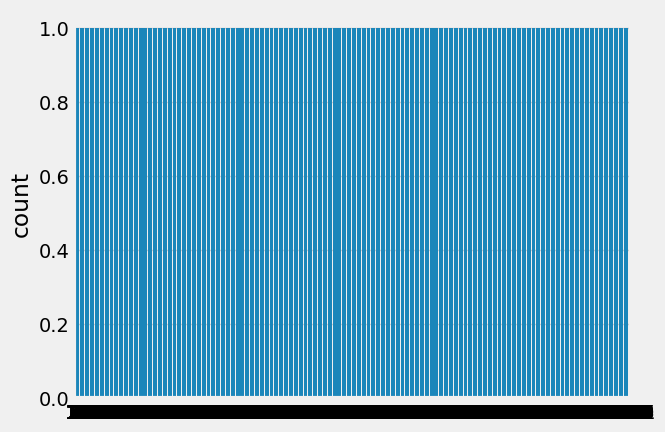

In [76]:
sns.countplot(y_df1, label = 'count')

### Model Definition

In [77]:
# def xgb_objective(space):

#     model = XGBClassifier(
#         learning_rate = space['learning_rate'],
#         n_estimators = int(space['n_estimators']),
#         max_depth = int(space['max_depth']),
#         min_child_weight = space['m_child_weight'],
#         gamma = space['gamma'],
#         subsample = space['subsample'],
#         scale_pos_weight = 6,
#         colsample_bytree = space['colsample_bytree'],
#         objective = 'binary:logistic'
#     )

#     model.fit(x_df, y_df)

#     predictions = model.predict(test_x)
#     test_preds = model.predict_proba(test_x)[:,1]
#     train_preds = model.predict_proba(x_df)[:,1]

#     xgb_booster = model.get_booster()
#     train_auc = roc_auc_score(y_df, train_preds)
#     test_auc = roc_auc_score(test_y, test_preds)
#     accuracy = accuracy_score(test_y, predictions)
#     F1 = f1_score(test_y, predictions)

#     return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
#             'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1
#            }

In [78]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

In [79]:
trials = Trials()

In [80]:
# xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
# display(xgb_results)

In [81]:
# Create XGBoost classifier model
xgb_model = XGBClassifier(
    learning_rate = 0.14972574734435318,
    n_estimators = 200,
    max_depth = 1,
    min_child_weight = 6,
    gamma = 0.5,
    subsample = 0.55,
    colsample_bytree = 1,
    scale_pos_weight = 6,
    objective = 'binary:logistic'
)

In [82]:
x_df.shape, y_df.shape

((1396, 45), (1396,))

In [83]:
xgb_model.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14972574734435318, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
xgb_model_dft = XGBClassifier()

In [85]:
xgb_model_dft.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Model Performance

In [86]:
# Model performance on all sets
predictions = xgb_model.predict(test_x)
test_preds = xgb_model.predict_proba(test_x)[:,1]
train_preds = xgb_model.predict_proba(x_df)[:,1]

xgb_booster = xgb_model.get_booster()

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [87]:
F1 = f1_score(test_y, predictions)
print(F1)

0.6470588235294118


Confusion Matrix

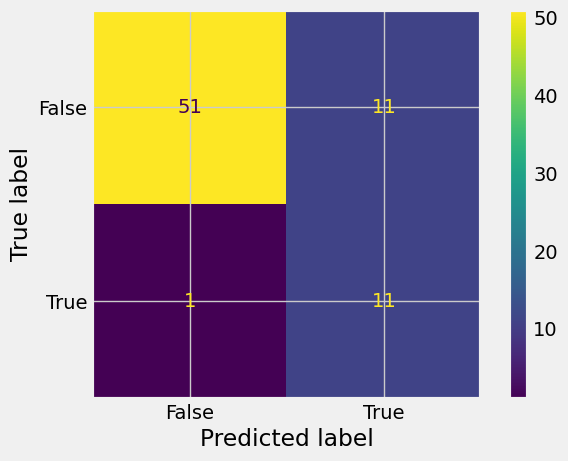

In [88]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

### Feature Importance

In [89]:
features = x_df.columns
importances_xgboost = xgb_model.feature_importances_

In [90]:
xgb_results = {'accuracy': accuracy,
              'model': 'XGBoost',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}
xgb_results

{'accuracy': 0.8378378378378378,
 'model': 'XGBoost',
 'f1_score': 0.6470588235294118,
 'test auc score': np.float64(0.9448924731182795),
 'training auc score': np.float64(0.9072663440554132)}

f1 score fell below, from 51 to 50.
* Overfitting is unaffected.

### Feature Engineering for LightGBM

In [91]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
lgb_data = train_ibm_df.copy()

# Handling categorical features
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)

# Concat the dummy variables to actual dataframe and remove initial categorical columns
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)

# Rename target column
lgb_data.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)

# Features
x_df = lgb_data.drop(columns='attrition')
# Target lebel
y_df = lgb_data['attrition'].reset_index(drop=True)
x_df.shape, y_df.shape

((1396, 45), (1396,))

<Axes: ylabel='count'>

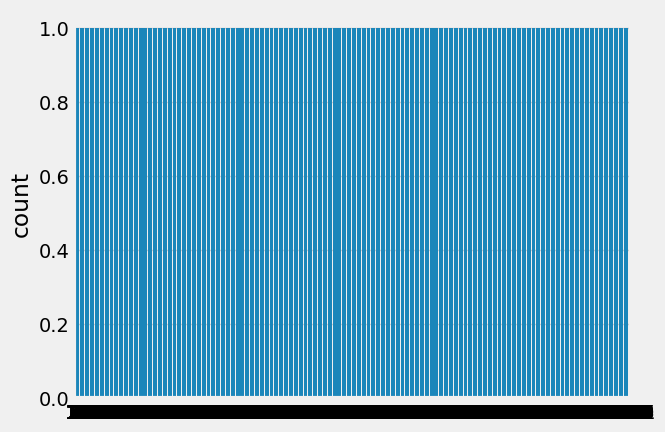

In [92]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)
sns.countplot(y_df1, label = 'count')

### Model Definition

In [93]:
def lgb_objective(space):

    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        scale_pos_weight = 5,
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )

    lgbm.fit(x_df, y_df)

    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(x_df)[:,1]

    train_auc = roc_auc_score(y_df, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1

           }

In [ ]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective,
                 max_evals = 150,
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

In [95]:
# # Create LightGBM classifier model
# lgbm = LGBMClassifier(
#     learning_rate = 0.15828893812295405,
#     n_estimators= 825,
#     max_depth = 8,
#     num_leaves = 110,
#     colsample_bytree = 0.6839759118900923,
#     feature_fraction = 0.3930665137463929,
#     reg_lambda = 0.8857198279892347,
#     reg_alpha = 0.8003856547872137,
#     min_split_gain = 0.07737786522996747
# )

In [96]:
# Create LightGBM classifier model
lgbm = LGBMClassifier(
    learning_rate = 1,
    n_estimators= 100,
    max_depth = 3,
    num_leaves = 31,
    colsample_bytree = 1,
    reg_lambda = 30,
    scale_pos_weight = 5,
    reg_alpha = 30,
    min_split_gain = 3
)

In [97]:
lgbm.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649513
[LightGBM] [Info] Start training from score -1.649513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier(colsample_bytree=1, learning_rate=1, max_depth=3,
               min_split_gain=3, reg_alpha=30, reg_lambda=30,
               scale_pos_weight=5)

In [98]:
lgbm_dft = LGBMClassifier()

In [99]:
lgbm_dft.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649513
[LightGBM] [Info] Start training from score -1.649513


LGBMClassifier()

### Model performance

In [100]:
# Model performance on all sets
predictions = lgbm.predict(test_x)
test_preds = lgbm.predict_proba(test_x)[:,1]
train_preds = lgbm.predict_proba(x_df1)[:,1]

train_auc = roc_auc_score(y_df1, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

F1 Score

In [101]:
F1 = f1_score(test_y, predictions)
print(F1)

0.27906976744186046


Confusion Matrix

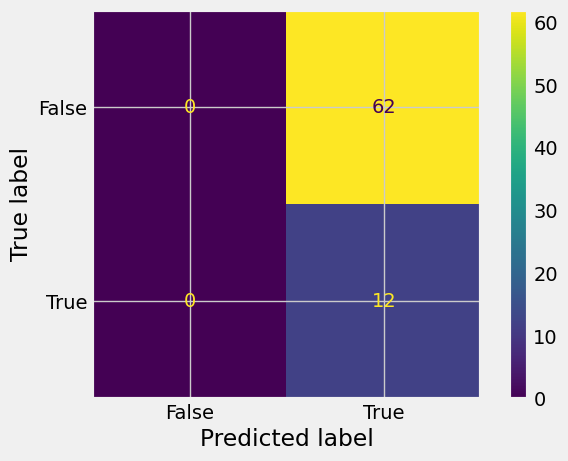

In [102]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

## Feature Importance

In [103]:
features = x_df.columns
importances_lgbm = lgbm.feature_importances_

In [104]:
lgbm_results = {'accuracy': accuracy,
              'model': 'LightGBM',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}

lgbm_results

{'accuracy': 0.16216216216216217,
 'model': 'LightGBM',
 'f1_score': 0.27906976744186046,
 'test auc score': np.float64(0.3064516129032258),
 'training auc score': np.float64(0.8557529274576825)}

f1 score drastically fell.
* Overfiiting is unaffected.

### Importances Dataframe

In [105]:
importances_cboost

array([7.592304  , 8.8730602 , 3.04921663, 0.09694601, 3.29387869,
       5.92808236, 2.49995959, 5.83242129, 2.35020024, 8.73256204,
       6.33081804, 2.35727549, 2.765142  , 0.        , 1.68088952,
       0.        , 4.19221578, 2.23672429, 1.05079514, 1.38854031,
       2.41827202, 2.25078347, 1.68216801, 5.84042422, 2.1540388 ,
       0.68876308, 2.93021591, 0.01756733, 0.04730278, 0.12581949,
       0.        , 0.        , 0.95912863, 0.45697858, 0.2690366 ,
       0.65201244, 0.        , 0.11218605, 0.49422597, 0.87887322,
       0.08838392, 0.27764796, 0.25028976, 0.24733597, 6.90751418])

In [106]:
print(np.round(importances_xgboost*100))

[4. 2. 2. 1. 3. 2. 3. 3. 3. 3. 2. 3. 2. 0. 2. 0. 7. 3. 2. 2. 2. 3. 3. 4.
 3. 2. 3. 3. 3. 0. 0. 0. 2. 2. 0. 2. 0. 0. 2. 3. 0. 5. 0. 2. 5.]


In [107]:
importances_lgbm

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
       1, 1, 0, 2, 0, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0,
       1], dtype=int32)

In [108]:
print(np.round(importances_cboost))

[8. 9. 3. 0. 3. 6. 2. 6. 2. 9. 6. 2. 3. 0. 2. 0. 4. 2. 1. 1. 2. 2. 2. 6.
 2. 1. 3. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 7.]


In [109]:
importances_df = pd.DataFrame()
importances_df['Feature Name'] = features
importances_df['Feature Imp CBoost'] = np.round(importances_cboost)
importances_df['Feature Imp XGBoost'] = np.round(importances_xgboost*100)
importances_df['Feature Imp LightBoost'] = importances_lgbm
importances_df.sort_values(['Feature Imp CBoost', 'Feature Imp XGBoost', 'Feature Imp LightBoost'], ascending=False)

,Feature Name,Feature Imp CBoost,Feature Imp XGBoost,Feature Imp LightBoost
9,gender_Male,9.0,3.0,0
1,businesstravel_Travel_Rarely,9.0,2.0,0
0,businesstravel_Travel_Frequently,8.0,4.0,1
44,yearswithcurrmanager,7.0,5.0,1
23,distancefromhome,6.0,4.0,1
7,educationfield_Other,6.0,3.0,0
5,educationfield_Marketing,6.0,2.0,0
10,jobrole_Human Resources,6.0,2.0,0
16,jobrole_Sales Executive,4.0,7.0,0
4,educationfield_Life Sciences,3.0,3.0,0


## Results

In [110]:
# Create a dataframe for computed metrics for different models
final_results = pd.DataFrame([xgb_results, lgbm_results, cboost_results])
display(final_results)

,accuracy,model,f1_score,test auc score,training auc score
0,0.837838,XGBoost,0.647059,0.944892,0.907266
1,0.162162,LightGBM,0.279070,0.306452,0.855753
2,0.851351,CatBoost,0.592593,0.881720,0.979861


- XGBoost is a wonderful algorithm with great documentation and many examples from years of use.
- LightGBM was clearly the fastest algorithm, often being 10x faster than XGBoost.
- In terms of accuracy the test and train dataset often had different balances of minority and majority class so 1-to-1 comparisons aren't perfect.
- CatBoost was the algorithm one can be most interested in using because of the supposed innovations in working with categorical data. Despite good accuracy however, several problems were faced.

    - CatBoost seemed significantly slower than the other algorithms, it seemed to stall on some evaluations. More experimentation may be needed with CatBoost and data that had lots of categorical features to get a better feel for when it may perform best.

* SMOTE was used to handle imabalance, it had no effect on the performance of all the three models.
* Using POS weight parameter to handle imabalace in all the three models helps give good results.
* K-fold cross validation technique was used while using train test split, performance of the model dipped.
* Outliers were handled but it had least effect on the performance.
* Three irrelevant features were dropped, it had no effect on the model performance.
* By far CatBoost is the best performing model followed by XGBoost whereas CatBoost takes longer to optimize parameters using Hyperopt, it is quick with XGBoost.
* Feature importance was calculated for all the three models.
* Based upon the importance 5 features were identified as not important. Removing these features while training dipped the performance of the models.

References:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/